In [2]:
# import libraries
import pandas as pd
import numpy as np
import time
import itertools
import pickle
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

import aaanalysis as aa
aa.options["verbose"] = False
aa.options["random_state"] = 42

In [7]:
# read MHCRules results
pephla_df = pd.read_csv('../results/MHCRule/mhcbench_v2_results/MHCRulePepHLA_mhcbenchv2.csv',index_col=0)
peponly_df = pd.read_csv('../results/MHCRule/mhcbench_v2_results/MHCRulePepOnly_mhcbenchv2.csv',index_col=0)
hydro_df = pd.read_csv('../results/MHCRule/mhcbench_v2_results/MHCRuleHydro_mhcbenchv2.csv',index_col=0)
hydropep_df = pd.read_csv('../results/MHCRule/mhcbench_v2_results/MHCRuleHydroPep_mhcbenchv2.csv',index_col=0)

predictors_auroc_df = pd.read_csv('../Data/mhcbench_v2_predictors_AUROC.csv',index_col=0)
predictors_auprc_df = pd.read_csv('../Data/mhcbench_v2_predictors_AUPRC.csv',index_col=0)

# keep hlas that are present in mhcrule results
predictors_auroc_df = predictors_auroc_df[predictors_auroc_df['allele'].isin(hydropep_df['allele'].unique())].reset_index(drop=True)
predictors_auprc_df = predictors_auprc_df[predictors_auprc_df['allele'].isin(hydropep_df['allele'].unique())].reset_index(drop=True)

scale = 'KOEH090101'


In [5]:
## constants
fontsize=14
dpi = 600
# color = 'Blue'
# color_palette = ['#814827','#F1DAAD','#ECF87F', '#81B622', '#59981A', '#3D550C']
color_palette = ['Plum', '#FFEBCD', '#003B73','#0074B7','#60A3D9','#BFD7ED']
color_palette = ['#BC8F8F', '#FFEBCD', '#BFD7ED','#60A3D9','#0074B7', '#003B73',]


In [6]:
predictors_auroc_df.median(), hydropep_df.median(), predictors_auprc_df.median()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


(MHCflurry-BA    0.984664
 MHCflurry-PS    0.986432
 MHCfovea        0.986989
 TransPHLA       0.982518
 NetMHCpan-BA    0.973118
 NetMHCpan-EL    0.977571
 dtype: float64,
 peptide_count    18961.000000
 accuracy             0.948028
 f1                   0.076636
 auroc                0.919944
 auprc                0.329186
 rule_count          59.000000
 dtype: float64,
 MHCflurry-BA    0.413604
 MHCflurry-PS    0.417884
 MHCfovea        0.487004
 TransPHLA       0.503807
 NetMHCpan-BA    0.352211
 NetMHCpan-EL    0.470054
 dtype: float64)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


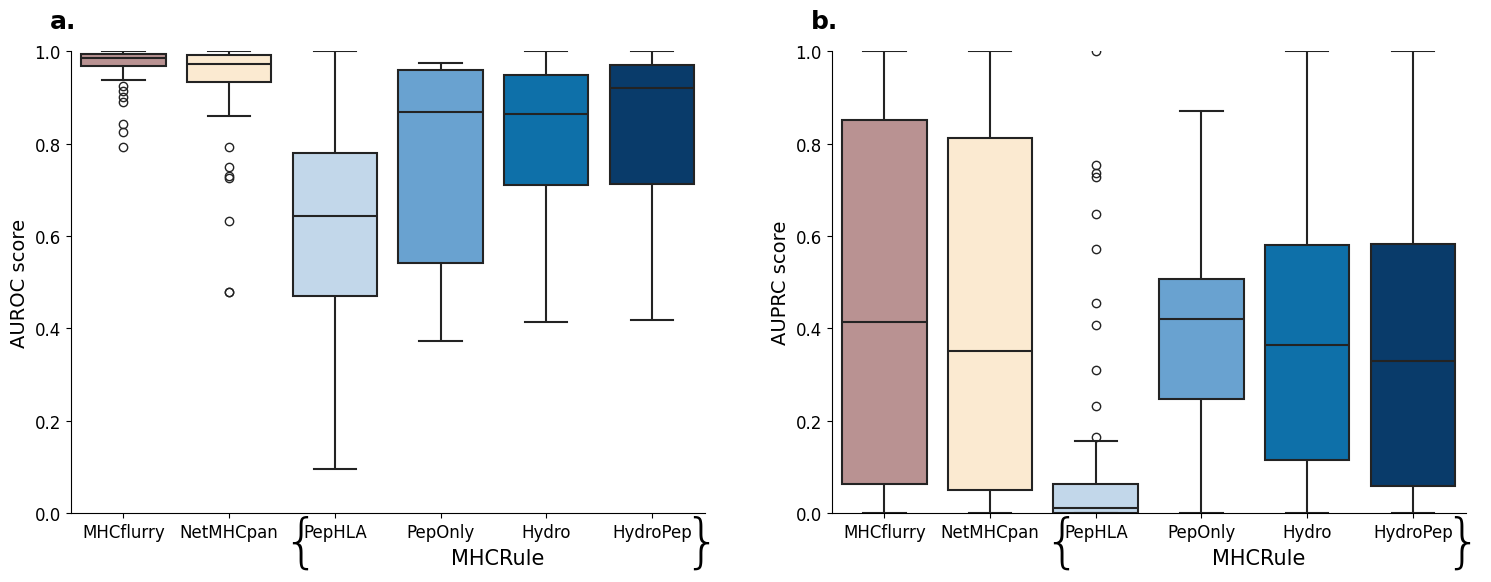

In [10]:
# Combine data
auroc_df = hydropep_df[['allele']].reset_index(drop=True)
auroc_df['MHCflurry'] = predictors_auroc_df['MHCflurry-BA'].reset_index(drop=True)
auroc_df['NetMHCpan'] = predictors_auroc_df['NetMHCpan-BA'].reset_index(drop=True)
auroc_df['PepHLA'] = pephla_df['auroc'].reset_index(drop=True)
auroc_df['PepOnly'] = peponly_df['auroc'].reset_index(drop=True)
auroc_df['Hydro'] = hydro_df['auroc'].reset_index(drop=True)
auroc_df['HydroPep'] = hydropep_df['auroc'].reset_index(drop=True)

auroc_df = auroc_df.drop('allele',axis=1).melt()

auprc_df = hydropep_df[['allele']].reset_index(drop=True)
auprc_df['MHCflurry'] = predictors_auprc_df['MHCflurry-BA'].reset_index(drop=True)
auprc_df['NetMHCpan'] = predictors_auprc_df['NetMHCpan-BA'].reset_index(drop=True)
auprc_df['PepHLA'] = pephla_df['auprc'].reset_index(drop=True)
auprc_df['PepOnly'] = peponly_df['auprc'].reset_index(drop=True)
auprc_df['Hydro'] = hydro_df['auprc'].reset_index(drop=True)
auprc_df['HydroPep'] = hydropep_df['auprc'].reset_index(drop=True)

auprc_df = auprc_df.drop('allele',axis=1).melt()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

b = sns.boxplot(data=auroc_df, x='variable', y='value', 
                ax=axs[0], saturation=0.85, linewidth=1.5,
               palette=color_palette)
plt.draw()
b.set_xticklabels(b.get_xticklabels(), rotation=0)
b.set_ylabel('AUROC score',fontsize=fontsize)
b.set_xlabel('',fontsize=fontsize)
b.set(ylim=(0,1))

b.text(-0.7,1.05,'a.', fontsize=fontsize+4, weight='bold')
b.text(1.5,-0.1,'{', fontsize=fontsize+28, weight='ultralight')
b.text(5.3,-0.1,'}', fontsize=fontsize+28, weight='ultralight')
b.text(3.1,-0.11,'MHCRule', fontsize=fontsize+1, weight='medium')

# Adding labels 
# Retrieve and modify existing y-axis tick labels fontsize
yticklabels = axs[0].get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)  # Set fontsize to 10
    
xticklabels = [i.get_text() for i in b.get_xticklabels()]
b.set_xticklabels(xticklabels,fontsize=fontsize-2,rotation=0)



b = sns.boxplot(data=auprc_df, x='variable', y='value', 
                ax=axs[1], saturation=0.85, linewidth=1.5,
               palette=color_palette)
plt.draw()
b.set_xticklabels(b.get_xticklabels(), rotation=0)
b.set(ylim=(0,1))
b.set_ylabel('AUPRC score',fontsize=fontsize)
b.set_xlabel('',fontsize=fontsize)

# Adding labels 
# Retrieve and modify existing y-axis tick labels fontsize
yticklabels = axs[1].get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)  # Set fontsize to 10
    
xticklabels = [i.get_text() for i in b.get_xticklabels()]
b.set_xticklabels(xticklabels,fontsize=fontsize-2,rotation=0)
b.text(-0.7,1.05,'b.', fontsize=fontsize+4, weight='bold')
b.text(1.5,-0.1,'{', fontsize=fontsize+28, weight='ultralight')
b.text(5.3,-0.1,'}', fontsize=fontsize+28, weight='ultralight')
b.text(3.1,-0.11,'MHCRule', fontsize=fontsize+1, weight='medium')

sns.despine(top=True, right=True)
fig.savefig('../figures/Benchmark/performance.png',bbox_inches="tight", dpi=dpi)